In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Enable GPU growth if necessary
for device in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)

Fri Jul  5 09:30:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   56C    P8              14W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!unzip /content/drive/MyDrive/texts_party.zip

In [ ]:
import os
import pandas as pd
import numpy as np
data = []
for party in os.listdir('/content/texts_party/'):
  for text in os.listdir('/content/texts_party/' + party):
    if party == "sp.a" or party == 'vooruit': #randomly select half of the vooruit / sp.a texts and merge into 'vooruit'
        choices = [True, False]
        choice = np.random.choice(choices,1)
        if choice:
          party_label = 'vooruit'
        else:
          continue
    else:
      party_label = party
    dir = '/content/texts_party/' + party + '/' + text
    file = open(dir, "r")
    content = file.read()
    file.close()
    data.append({'text': content, 'label': party_label})

df = pd.DataFrame(data)

In [ ]:
df_aggregated['Median_Entropy'].var()

KeyError: 'Median_Entropy'

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertForSequenceClassification

In [ ]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
num_classes = len(set(df['label_encoded']))

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label_encoded'], random_state=42)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize and prepare input features
def encode_texts(texts, tokenizer, max_length=128):
    return tokenizer(texts.tolist(), max_length=max_length, padding=True, truncation=True, return_tensors='tf')

# Tokenize the training and test data
train_encodings = encode_texts(train_df['text'], tokenizer)
test_encodings = encode_texts(test_df['text'], tokenizer)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_df['label_encoded'].values)).shuffle(len(train_df)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_df['label_encoded'].values)).batch(32)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, validation_data=test_dataset, epochs=5)

# Save the model
model.save_pretrained('/content/drive/MyDrive/bert-party_classification')

# Evaluate the model
evaluation = model.evaluate(test_dataset)
print(f"Test Accuracy: {evaluation[1]:.4f}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1063/1063 [==============================] - 533s 428ms/step - loss: 1.1365 - accuracy: 0.4844 - val_loss: 1.0619 - val_accuracy: 0.5326
Epoch 2/5
1063/1063 [==============================] - 445s 419ms/step - loss: 1.0468 - accuracy: 0.5406 - val_loss: 1.0502 - val_accuracy: 0.5319
Epoch 3/5
1063/1063 [==============================] - 445s 418ms/step - loss: 0.9893 - accuracy: 0.5731 - val_loss: 1.0311 - val_accuracy: 0.5448
Epoch 4/5
1063/1063 [==============================] - 445s 418ms/step - loss: 0.9195 - accuracy: 0.6076 - val_loss: 1.0556 - val_accuracy: 0.5438
Epoch 5/5
188/188 [==============================] - 24s 127ms/step - loss: 1.2180 - accuracy: 0.5363
Test Accuracy: 0.5363


In [ ]:
!unzip /content/drive/MyDrive/texts.zip

In [ ]:
from scipy.stats import entropy


def preprocess_text(text):
  inputs = tokenizer(text, return_tensors = "tf", padding=True, truncation=True, max_length=512)
  return inputs

def compute_entropy(probabilities):
  return entropy(probabilities, base=2)

In [ ]:
import os

model = TFBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/bert-party_classification')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

data = []
gen_person = (pers for pers in os.listdir('/content/texts/') if pers not in df['person'].unique())
for person in gen_person:
  for text in os.listdir('/content/texts/' + person):
    dir = '/content/texts/' + person + '/' + text
    file = open(dir, "r")
    content = file.read()
    file.close()
    inputs = preprocess_text(content)
    outputs = model(inputs)
    logits = outputs.logits
    probabilities = tf.nn.softmax(logits, axis=-1).numpy().flatten()
    entropy_score = compute_entropy(probabilities)
    data.append({'text': content, 'person': person, 'text_id': text, 'entropy': entropy_score})

df_v2 = pd.DataFrame(data)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/bert-party_classification.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df = pd.DataFrame(data)

NameError: name 'data' is not defined

In [ ]:
df_v2

,text,person,text_id,entropy
0,"Een mooie, glazen fles water, met het logo van...",gerrit budts,103.txt,1.902138
1,Liefst 120.000 Belgen zweerden vorig jaar een ...,gerrit budts,95.txt,1.823194
2,Hittegolven en ijsjes: het is de perfecte matc...,gerrit budts,85.txt,0.770592
3,"“Ze hadden ons 360 overuren beloofd, maar ons ...",gerrit budts,58.txt,0.957655
4,He t einde van de lage rente en van decoronast...,gerrit budts,187.txt,1.863524
...,...,...,...,...
12276,@EA_CoR @CllrGillianFord @cllrkmac @MairiGouge...,karl vanlouwe,186.txt,0.303174
12277,Het staatsmanschap van enkele partijvoorzitter...,karl vanlouwe,17.txt,1.788003
12278,Vlaams parlementslid en gemeenteraadslid in Ga...,karl vanlouwe,77.txt,1.912417
12279,En nog een schandaal : Brussels Expo betaalde ...,karl vanlouwe,189.txt,1.533695


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
df.to_csv('/content/drive/MyDrive/entropies_v1.csv')

In [ ]:
df_1 = pd.read_csv('/content/drive/MyDrive/entropies_v1.csv')
df_2 = pd.read_csv('/content/drive/MyDrive/entropies_v2.csv')
df_3 = pd.read_csv('/content/drive/MyDrive/entropies_v3.csv')

df = pd.concat([df_1,df_2,df_3])

In [ ]:
pip install google-cloud-translate

In [ ]:
# OPGEPAST F ING DUUR!!!!!!!!!!
# from google.cloud import translate_v2 as translate
# import os
# import re

# # Set the environment variable for authentication
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/paperiii-875d50057e3a.json"

# # Initialize the Translator
# translate_client = translate.Client()

# def split_text(text, max_length=5000):
#     text_chunks = re.findall('.{1,%d}(?:\s|$)' % max_length, text)
#     return text_chunks

# def translate_text(text, target_language='en'):
#     text_chunks = split_text(text)
#     translated_chunks = []

#     for chunk in text_chunks:
#         result = translate_client.translate(chunk, target_language=target_language)
#         translated_chunks.append(result['translatedText'])

#     return ' '.join(translated_chunks)
# OPGEPAST F ING DUUR!!!!!!!!!!



KeyboardInterrupt: 

In [ ]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
gmm = GaussianMixture(n_components=2, random_state=0)
entropy_scores = df['entropy'].values.reshape(-1,1)

gmm.fit(entropy_scores)
df['entropy_labels'] = gmm.predict(entropy_scores)

In [ ]:
def count_characters(text):
    return len(str(text))

# Apply character count function to each row in the 'text' column
df['char_count'] = df['text'].apply(count_characters)

In [ ]:
df['char_count'].sum()


239096142

In [ ]:
df_aggregated['Med_Entropy'].var()

0.23174687991446796

[Text(0.5, 0, 'Entropy H(X)'),
 Text(0.5, 1.0, 'Historgram of Text-level Entropy')]

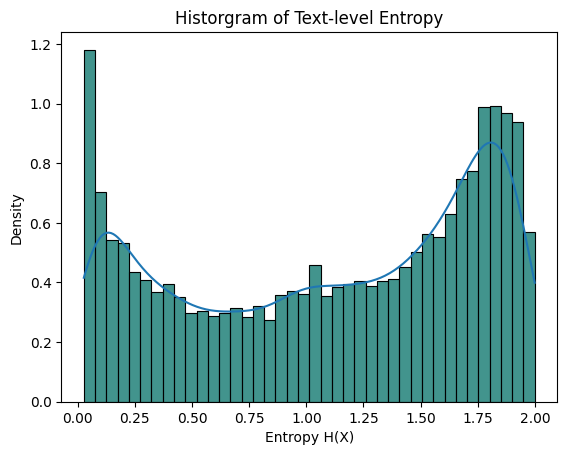

In [ ]:
plt.hist(entropy_scores, bins = 40, density=True, alpha = 0.6, color='g')

import seaborn
seaborn.histplot(entropy_scores, bins = 40, stat='density', kde=True, legend=False).set(xlabel='Entropy H(X)', title='Historgram of Text-level Entropy')

In [ ]:
df_aggregated = df.groupby("person").agg(
    Max_Entropy=("entropy", "max"),
    Min_Entropy=("entropy", "min"),
    Avg_Entropy=("entropy", "mean"),
    Med_Entropy=("entropy", "median")
).reset_index()



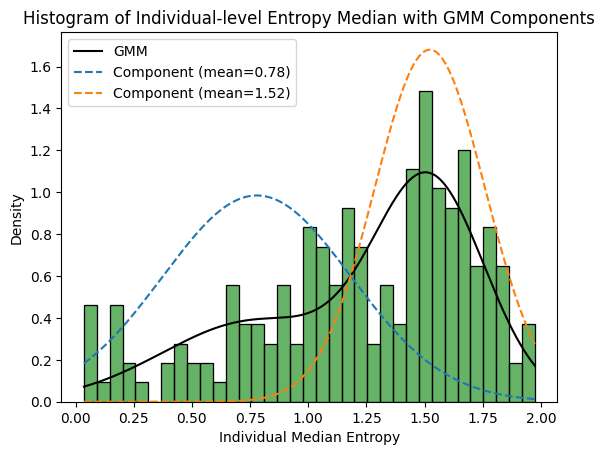

Gaussian Component 0:
  Mean: 0.7792
  Variance: 0.1641
  Weight: 0.3927

Gaussian Component 1:
  Mean: 1.5229
  Variance: 0.0564
  Weight: 0.6073



In [ ]:

from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
gmm = GaussianMixture(n_components=2, random_state=0)
entropy_ind = df_aggregated['Med_Entropy'].values.reshape(-1,1)

gmm.fit(entropy_ind)
x = np.linspace(min(entropy_ind), max(entropy_ind), 1000).reshape(-1, 1)
df_aggregated['entropy_labels'] = gmm.predict(entropy_ind)

# Plot the histogram of the entropy scores using Seaborn
seaborn.histplot(entropy_ind.flatten(), bins=35, kde=False, stat="density", color='g', alpha=0.6)

# Calculate the log probability and convert to probability
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)

# Plot the overall GMM PDF
plt.plot(x, pdf, '-k', label='GMM')

# Extract the means and covariances of the GMM components
means = gmm.means_.flatten()
covariances = gmm.covariances_.flatten()

# Plot each Gaussian component
for mean, covar in zip(means, covariances):
    component_pdf = (1 / np.sqrt(2 * np.pi * covar)) * np.exp(-(x - mean)**2 / (2 * covar))
    plt.plot(x, component_pdf, linestyle='--', label=f'Component (mean={mean:.2f})')

# Add labels and legend
plt.xlabel('Individual Median Entropy')
plt.ylabel('Density')
plt.title('Histogram of Individual-level Entropy Median with GMM Components')
plt.legend()

# Show the plot
plt.show()

means = gmm.means_.flatten()
variances = gmm.covariances_.flatten()
weights = gmm.weights_.flatten()

# Print descriptive statistics for each Gaussian component
for i in range(len(means)):
    print(f"Gaussian Component {i}:")
    print(f"  Mean: {means[i]:.4f}")
    print(f"  Variance: {variances[i]:.4f}")
    print(f"  Weight: {weights[i]:.4f}")
    print()

<Axes: xlabel='entropy_labels', ylabel='Count'>

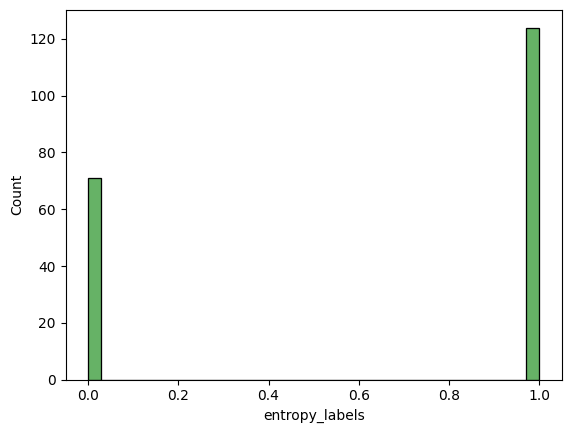

In [ ]:
seaborn.histplot(df_aggregated['entropy_labels'], bins=35, kde=False, stat="count", color='g', alpha=0.6)

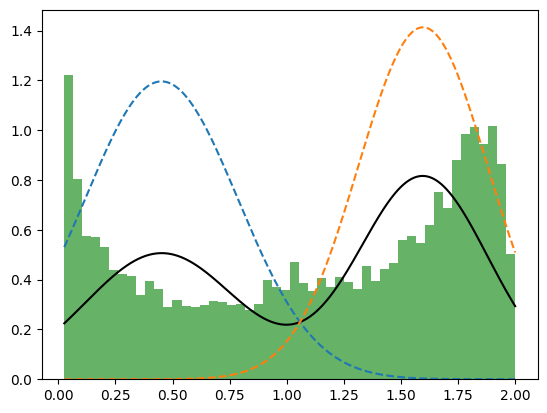

In [ ]:
x = np.linspace(min(entropy_scores), max(entropy_scores),1000).reshape(-1,1)
plt.hist(entropy_scores, bins = 50, density=True, alpha = 0.6, color='g')
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)
plt.plot(x, pdf, '-k')

means = gmm.means_.flatten()
covariances = gmm.covariances_.flatten()

for mean, covar in zip(means, covariances):
  component_pdf = (1/np.sqrt(2* np.pi * covar)) * np.exp(-(x-mean)**2 / (2 * covar))
  plt.plot(x, component_pdf, linestyle='--')

plt.show()


In [ ]:
df_links = pd.read_csv('/content/drive/MyDrive/links_df_libis_part_1.csv')

In [ ]:
df_links

,Unnamed: 0,link
0,0,https://icandid.libis.be/export/Mr65Xb
1,1,https://icandid.libis.be/export/xHA33f
2,2,https://icandid.libis.be/export/102WDd
3,3,https://icandid.libis.be/export/j7clZG
4,4,https://icandid.libis.be/export/3L9nyB
...,...,...
294,294,https://icandid.libis.be/export/CwGHgv
295,295,https://icandid.libis.be/export/0sFTx9
296,296,https://icandid.libis.be/export/K9wDIp
297,297,https://icandid.libis.be/export/CTOkIE


In [ ]:
import requests
import os

In [ ]:
url = 'https://linkedin-parsing-49a53bd295b9.herokuapp.com/advisers'
api_key = '6d8cc2da-a838-4d0a-ba83-efd9b5f87b89'
headers = {
    'Authorization': f'{api_key}',
    'Content-Type': 'application/json',
}

response = requests.get(url, headers=headers)


In [ ]:
from dateutil import parser

def extract_year(date_str):
  date_str= translate_month(date_str)
  if date_str == 'Present':
    date_str = "2023"
  try:
    date_obj = parser.parse(date_str)
    return date_obj.year
  except (ValueError, OverflowError, TypeError):
    print('error parsing: ' + str(date_str))
    return None


In [ ]:
def translate_month(date_str):
  dutch_to_english_months  = {'januari': 'January', 'februari': 'February', 'maart': 'March', 'april': 'April', 'mei': 'May', 'juni': 'June', 'juli': 'July', 'augustus': 'August', 'september': 'September', 'oktober': 'October', 'november': 'November', 'december': 'December'}
  for dutch, english in dutch_to_english_months.items():
    try:
      if dutch in date_str:
        return date_str.replace(dutch, english)
    except:
        return date_str
  return date_str

In [ ]:
advisers = response.json()
linked_advisers = []
for individual in advisers:
  if individual['li-status'] == 'Linked':
      linked_advisers.append({'id': individual['id'], 'first-name': individual['first-name'], 'name': individual['name'], 'positions': []})

#get all positions for person

In [ ]:
url_positions = 'https://linkedin-parsing-49a53bd295b9.herokuapp.com/advisers/'
adviser_list = (adv for adv in linked_advisers if len(adv['positions']) == 0)
for adviser in adviser_list:
  response_positions = requests.get(url_positions + str(adviser['id']) + "/positions", headers=headers)
  for position in response_positions.json():
    start_date = extract_year(position['start-date'])
    end_date = extract_year(position['end-date'])
    url_codes = 'https://linkedin-parsing-49a53bd295b9.herokuapp.com/positions/' + str(position['id']) + '/codes'
    response_codes = requests.get(url_codes, headers=headers)
    for code in response_codes.json():
      if code['name'] == 'sector':
        adviser['positions'].append({'start': start_date, 'end': end_date, 'value': code['value']})

NameError: name 'extract_year' is not defined

In [ ]:
advisers_indexed = []

for adviser in linked_advisers:
  total_duration = 0
  total_pos = 0
  pol_duration = 0
  pol_pos = 0
  pub_duration = 0
  pub_pos = 0
  for position in adviser['positions']:
    if 'board' not in position['value'] and position['start'] is not None and position['end'] is not None:
      total_duration = total_duration + (position['end'] - position['start']) + 1
      total_pos = total_pos + 1
      if 'politics' in position['value']:
        pol_duration = pol_duration + (position['end'] - position['start']) + 1
        pol_pos = pol_pos + 1
      if 'public' in position['value']:
        pub_duration = pub_duration + (position['end'] - position['start']) + 1
        pub_pos = pub_pos + 1
  advisers_indexed.append({'id': adviser['id'], 'first-name': adviser['first-name'], 'name': adviser['name'],
                           'tot-dur': total_duration, 'tot-pos': total_pos, 'pol-dur': pol_duration,
                           'pol-pos': pol_pos, 'pub_duration': pub_duration, 'pub-pos': pub_pos,
                           'pol_idx': pol_duration / total_duration, 'pub_idx': pub_duration / total_duration})


In [ ]:
advisers_idxed = pd.DataFrame(advisers_indexed)

In [ ]:
advisers_idxed

,id,first-name,name,tot-dur,tot-pos,pol-dur,pol-pos,pub_duration,pub-pos,pol_idx,pub_idx,mean_entr,max_entr,min_entr,labels_avg
0,6425,Mariam,AL MERROUNI,28,3,18,2,10,1,0.642857,0.357143,NaN,NaN,NaN,NaN
1,6429,Peter,RAEYMAEKERS,30,5,3,1,2,1,0.100000,0.066667,NaN,NaN,NaN,NaN
2,6436,Ayan,MOHAMUD YUSUF,31,4,31,4,0,0,1.000000,0.000000,NaN,NaN,NaN,NaN
3,6437,Leen,VERRAEST,36,10,7,2,6,1,0.194444,0.166667,NaN,NaN,NaN,NaN
4,6438,Valerie,HELLEBUCK,19,5,4,1,7,1,0.210526,0.368421,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,7059,Sven,LIETEN,146,13,91,8,46,4,0.623288,0.315068,1.475779,1.994020,0.042682,0.830357
337,7073,Geert,DEDECKER,25,6,25,6,0,0,1.000000,0.000000,1.074180,1.838305,0.143080,0.454545
338,7098,Helena,MUYLDERMANS,19,7,14,5,2,1,0.736842,0.105263,NaN,NaN,NaN,NaN
339,7118,Christian,FIEREMANS,42,9,24,6,8,2,0.571429,0.190476,NaN,NaN,NaN,NaN


In [ ]:
advisers_idxed.to_csv('/content/drive/MyDrive/advisers_polpub.csv')

In [ ]:
len(df['person'].unique())

195

In [ ]:
advisers_idxed = pd.read_csv('/content/drive/MyDrive/advisers_polpub.csv')

In [ ]:

for person in df['person'].unique():
  mean_entr = df[df['person'] == person]['entropy'].mean()
  max_entr = df[df['person'] == person]['entropy'].max()
  min_entr = df[df['person'] == person]['entropy'].min()
  labels_avg = df[df['person'] == person]['entropy_labels'].mean()


In [ ]:
advisers_indexed = []

for adviser in linked_advisers:
  person = adviser['first-name'].lower() + ' ' + adviser['name'].lower()
  mean_entr = df[df['person'] == person]['entropy'].mean()
  max_entr = df[df['person'] == person]['entropy'].max()
  min_entr = df[df['person'] == person]['entropy'].min()
  labels_avg = df[df['person'] == person]['entropy_labels'].mean()
  total_duration = 0
  total_pos = 0
  pol_duration = 0
  pol_pos = 0
  pub_duration = 0
  pub_pos = 0
  for position in adviser['positions']:
    if 'board' not in position['value'] and position['start'] is not None and position['end'] is not None:
      total_duration = total_duration + (position['end'] - position['start']) + 1
      total_pos = total_pos + 1
      if 'politics' in position['value']:
        pol_duration = pol_duration + (position['end'] - position['start']) + 1
        pol_pos = pol_pos + 1
      if 'public' in position['value']:
        pub_duration = pub_duration + (position['end'] - position['start']) + 1
        pub_pos = pub_pos + 1
  advisers_indexed.append({'id': adviser['id'], 'first-name': adviser['first-name'], 'name': adviser['name'],
                           'tot-dur': total_duration, 'tot-pos': total_pos, 'pol-dur': pol_duration,
                           'pol-pos': pol_pos, 'pub_duration': pub_duration, 'pub-pos': pub_pos,
                           'pol_idx': pol_duration / total_duration, 'pub_idx': pub_duration / total_duration,
                           'mean_entr': mean_entr, 'max_entr': max_entr, 'min_entr': min_entr, 'labels_avg': labels_avg})


NameError: name 'linked_advisers' is not defined

In [ ]:
advisers_table= []

for idx, adviser in advisers_idxed.iterrows():
  print(adviser)

  person = str(adviser['first-name']).lower() + ' ' + adviser['name'].lower()
  mean_entr = df[df['person'] == person]['entropy'].mean()
  max_entr = df[df['person'] == person]['entropy'].max()
  min_entr = df[df['person'] == person]['entropy'].min()
  labels_avg = df[df['person'] == person]['entropy_labels'].mean()
  advisers_table.append({'id': adviser['id'], 'first-name': adviser['first-name'], 'name': adviser['name'],
                           'tot-dur': adviser['tot-dur'], 'tot-pos': adviser['tot-pos'], 'pol-dur': adviser['pol-dur'],
                           'pol-pos': adviser['pol-pos'], 'pub_duration': adviser['pub_duration'], 'pub-pos': adviser['pub-pos'],
                           'pol_idx': adviser['pol_idx'] , 'pub_idx': adviser['pub_idx'],
                           'mean_entr': mean_entr, 'max_entr': max_entr, 'min_entr': min_entr, 'labels_avg': labels_avg})

In [ ]:
advisers_df = pd.DataFrame(advisers_table)
advisers_df.to_csv('/content/drive/MyDrive/advisers_metrics.csv')

In [ ]:
import scipy

spro_pol = scipy.stats.spearmanr(advisers_df['pol_idx'], advisers_df['mean_entr'], nan_policy='omit')
print(spro_pol)

spro_pub = scipy.stats.spearmanr(advisers_df['pub_idx'], advisers_df['mean_entr'], nan_policy='omit')
print(spro_pub)


SignificanceResult(statistic=-0.15156514344517683, pvalue=0.03441977301460811)
SignificanceResult(statistic=0.1328891165379505, pvalue=0.06402766860740246)


,Unnamed: 0,text,person,text_id,entropy
0,0,"Een mooie, glazen fles water, met het logo van...",gerrit budts,103.txt,1.902138
1,1,Liefst 120.000 Belgen zweerden vorig jaar een ...,gerrit budts,95.txt,1.823194
2,2,Hittegolven en ijsjes: het is de perfecte matc...,gerrit budts,85.txt,0.770592
3,3,"“Ze hadden ons 360 overuren beloofd, maar ons ...",gerrit budts,58.txt,0.957655
4,4,He t einde van de lage rente en van decoronast...,gerrit budts,187.txt,1.863524
...,...,...,...,...,...
12276,12276,@EA_CoR @CllrGillianFord @cllrkmac @MairiGouge...,karl vanlouwe,186.txt,0.303174
12277,12277,Het staatsmanschap van enkele partijvoorzitter...,karl vanlouwe,17.txt,1.788003
12278,12278,Vlaams parlementslid en gemeenteraadslid in Ga...,karl vanlouwe,77.txt,1.912417
12279,12279,En nog een schandaal : Brussels Expo betaalde ...,karl vanlouwe,189.txt,1.533695


In [ ]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 9.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 M

In [ ]:
!pip install stop-words

  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=2513f02ac65d76b56c96918305d540f5d4dfc92d39417516875f6f49b97da985
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop-words


In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from stop_words import get_stop_words

vectorizer_model = CountVectorizer(stop_words=get_stop_words('dutch'))
topic_model = BERTopic(calculate_probabilities=True, nr_topics='auto', vectorizer_model = vectorizer_model, language="multilingual")


topics, probabilities = topic_model.fit_transform(df['text'].astype(str).tolist())
new_topics = topic_model.reduce_outliers(df['text'].astype(str).tolist(), topics, strategy='c-TF-IDF')
topic_model.update_topics(df['text'].astype(str).tolist(), topics=new_topics)
topics_reduced, probabilities_reduced = topic_model.transform(df['text'].astype(str).tolist())

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

2024-07-10 12:39:17,770 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
umap_model = topic_model.umap_model
umap_embeddings = umap_model.embedding_

# Add the UMAP coordinates to the DataFrame
df['x'] = umap_embeddings[:, 0]
df['y'] = umap_embeddings[:, 1]

# Add the UMAP embeddings as columns to the DataFrame
df['embedding'] = list(umap_embeddings)

In [ ]:
df

,Unnamed: 0,text,person,text_id,entropy,x,y
0,0,"Een mooie, glazen fles water, met het logo van...",gerrit budts,103.txt,1.902138,9.323780,3.421753
1,1,Liefst 120.000 Belgen zweerden vorig jaar een ...,gerrit budts,95.txt,1.823194,8.481165,3.888943
2,2,Hittegolven en ijsjes: het is de perfecte matc...,gerrit budts,85.txt,0.770592,9.390232,3.308525
3,3,"“Ze hadden ons 360 overuren beloofd, maar ons ...",gerrit budts,58.txt,0.957655,10.629059,3.608463
4,4,He t einde van de lage rente en van decoronast...,gerrit budts,187.txt,1.863524,9.482660,3.000046
...,...,...,...,...,...,...,...
1714,1714,"""Ik loop de muren op."" Een directeur van een g...",peter marquebreuck,16.txt,1.944748,9.009544,3.151002
1715,1715,"Vijftig van de 180 bewoners ­besmet, tien over...",peter marquebreuck,13.txt,1.738748,8.683382,3.003908
1716,1716,Jorgen Deman haalde met vier collega's de eind...,peter marquebreuck,1.txt,1.817930,10.148903,4.196414
1717,1717,'Het is onbegrijpelijk dat de CD&V-meerderheid...,peter marquebreuck,7.txt,1.855709,10.003028,2.883104


                      person  average_cosine_similarity  count       label
0                 de ceuster                   0.988560    200  generalist
1             aidan reinquin                   0.981926     56  specialist
2    alexander vandersmissen                   0.987923    200  generalist
3             allessia claes                   0.906120    200  specialist
4                   an moons                   0.999989    200  generalist
..                       ...                        ...    ...         ...
294        wouter coussement                   0.000000      1          NA
295               wouter pas                   0.991318    200  generalist
296             wouter patho                   0.988476    200  generalist
297              yago bastin                   0.000000      1          NA
298           yves de keyzer                   0.000000      1          NA

[299 rows x 4 columns]


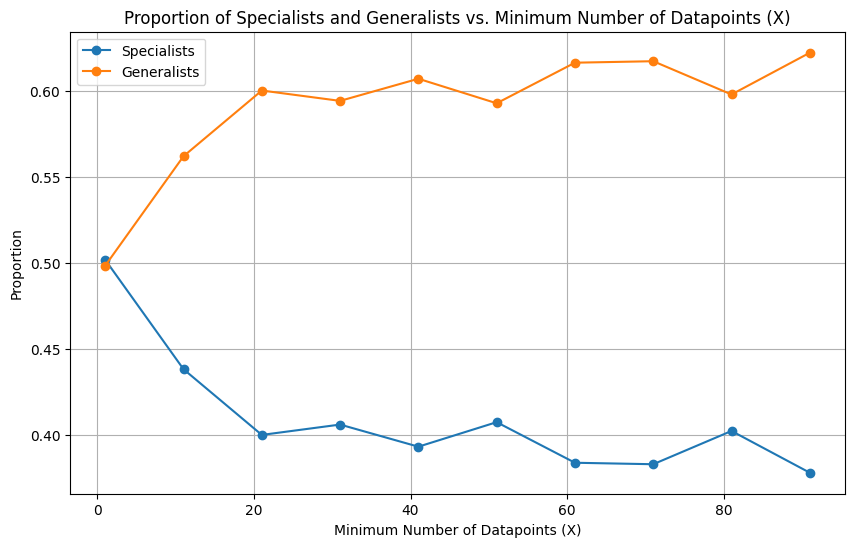

In [ ]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

def calculate_average_cosine_similarity(group):
    embeddings = np.array(group['embedding'].tolist())
    n = len(embeddings)
    if n < 2:
        return 0  # Not enough points to calculate similarity
    cosine_similarities = []
    for i in range(n):
        for j in range(i + 1, n):
            cosine_similarities.append(1 - cosine(embeddings[i], embeddings[j]))
    return np.median(cosine_similarities)

# Aggregate by person and calculate average cosine similarity
similarity_df = df.groupby('person').apply(calculate_average_cosine_similarity).reset_index()
similarity_df.columns = ['person', 'average_cosine_similarity']

# Calculate the overall average cosine similarity across all persons
overall_average_similarity = similarity_df['average_cosine_similarity'].median()

# Set the minimum number of datapoints required
min_datapoints = 3

# Calculate the number of datapoints for each person
counts = df['person'].value_counts().reset_index()
counts.columns = ['person', 'count']

# Merge the counts with the similarity dataframe
similarity_df = similarity_df.merge(counts, on='person')

# Label each person as "specialist" or "generalist" or "NA"
def label_person(row, overall_average_similarity, min_datapoints):
    if row['count'] < min_datapoints:
        return 'NA'
    elif row['average_cosine_similarity'] > overall_average_similarity:
        return 'generalist'
    else:
        return 'specialist'

similarity_df['label'] = similarity_df.apply(label_person, axis=1, overall_average_similarity=overall_average_similarity, min_datapoints=min_datapoints)

# Display the similarity DataFrame with labels
print(similarity_df)

# Initialize lists to store proportions
x_values = range(1, 100, 10)
proportion_specialists = []
proportion_generalists = []

# Calculate proportions for each value of X
for min_datapoints in x_values:
    similarity_df['label'] = similarity_df.apply(label_person, axis=1, overall_average_similarity=overall_average_similarity, min_datapoints=min_datapoints)
    total = similarity_df['label'].value_counts()
    num_specialists = total.get('specialist', 0)
    num_generalists = total.get('generalist', 0)
    num_total = num_specialists + num_generalists
    if num_total > 0:
        proportion_specialists.append(num_specialists / num_total)
        proportion_generalists.append(num_generalists / num_total)
    else:
        proportion_specialists.append(0)
        proportion_generalists.append(0)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'X': x_values,
    'Proportion_Specialists': proportion_specialists,
    'Proportion_Generalists': proportion_generalists
})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(plot_df['X'], plot_df['Proportion_Specialists'], label='Specialists', marker='o')
plt.plot(plot_df['X'], plot_df['Proportion_Generalists'], label='Generalists', marker='o')
plt.xlabel('Minimum Number of Datapoints (X)')
plt.ylabel('Proportion')
plt.title('Proportion of Specialists and Generalists vs. Minimum Number of Datapoints (X)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
similarity_df

,person,average_cosine_similarity,count,label
0,de ceuster,0.990860,200,generalist
1,aidan reinquin,0.983836,56,NA
2,alexander vandersmissen,0.989327,200,generalist
3,allessia claes,0.919704,200,specialist
4,an moons,0.999977,200,generalist
...,...,...,...,...
294,wouter coussement,0.000000,1,NA
295,wouter pas,0.994807,200,generalist
296,wouter patho,0.990253,200,generalist
297,yago bastin,0.000000,1,NA


In [ ]:
topic_model.visualize_topics()

In [ ]:
print(topic_model.visualize_documents)

In [ ]:
fig = topic_model.visualize_documents(df['text'].astype(str).tolist())
x = [point['x'] for point in fig.data[0]['customdata']]
y = [point['y'] for point in fig.data[0]['customdata']]

# Add the 2D coordinates to the DataFrame
df['x'] = x
df['y'] = y

# Function to calculate variance in 2D space
def calculate_variance(group):
    return np.var(group[['x', 'y']], axis=0).mean()

# Aggregate by name and calculate variance
variance_df = df.groupby('name').apply(calculate_variance).reset_index()
variance_df.columns = ['name', 'variance']

# Display the variance DataFrame
print(variance_df)

TypeError: 'NoneType' object is not iterable

In [ ]:
len(fig.data)

176

In [ ]:
df.to_csv('/content/drive/MyDrive/entropies_and_probs.csv')

In [ ]:
probabilities_list = [probabilities[i] for i in range(len(probabilities))]

# Assign the list of numpy arrays to a new column in the DataFrame
df["prob_vector"] = probabilities_list

# Ensure that the Probability_Vector column contains numpy arrays
df["prob_vector"] = df["prob_vector"].apply(np.array)

In [ ]:
probabilities_list

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
pairwise_distances_cosine = pdist(np.stack(df['prob_vector']), metric='cosine')
pairwise_distances_euclidean = pdist(np.stack(df['prob_vector']), metric='euclidean')

avg_distances_cosine = pairwise_distances_cosine.mean()
avg_distances_euclidean = pairwise_distances_euclidean.mean()

var_distances_cosines = pairwise_distances_cosine.var()
var_distances_euclidean = pairwise_distances_euclidean.var()
persons_topic_df = []
for person in df['person'].unique():
  person_df = df[df['person'] == person]
  person_probs = np.stack(person_df['prob_vector'].values)
  print(person_probs.shape)
  person_pairwise_distances_euclidean = pdist(person_probs, metric='euclidean')
  person_pairwise_distances_cosine = pdist(person_probs, metric='cosine')

  person_avg_distances_cosine = person_pairwise_distances_cosine.mean()
  person_avg_distances_euclidean = person_pairwise_distances_euclidian.mean()
  person_var_distances_cosines = person_pairwise_distances_cosine.var()
  person_var_distances_euclidean = person_pairwise_distances_euclidian.var()
  persons_topic_df.append({'person': person, 'person_avg_cos': person_avg_distances_cosine, 'person_avg_euclid': person_avg_distances_euclid, 'person_var_cos': person_var_distances_cosines, 'person_var_eucl': person_var_distances_euclid})


In [ ]:
person_topic_df = pd.DataFrame(persons_topic_df)

In [ ]:
person_topic_df

,person,person_avg_cos,person_avg_euclid,person_var_cos,person_var_eucl
0,gerrit budts,0.530352,0.352196,0.102550,0.165970
1,maurits vande reyde,0.680081,0.433138,0.115242,0.174193
2,kurt sannen,0.706098,0.627491,0.130898,0.221139
3,veerle van nieuwenhuysen,0.611088,0.179065,0.080971,0.052344
4,pieter jan,0.660572,0.338154,0.103617,0.132670
...,...,...,...,...,...
294,karlijn deene,0.514622,0.280269,0.100290,0.125468
295,peter verplancken,0.554821,0.269922,0.084689,0.107628
296,sarah d'haen,NaN,NaN,NaN,NaN
297,ann vandenbulcke,0.041150,0.024973,0.000000,0.000000


In [ ]:
person_topic_df['above_avg_cos'] = (person_topic_df['person_avg_cos'] > avg_distances_cosine).astype(int)
person_topic_df['above_avg_euclid'] = (person_topic_df['person_avg_euclid'] > avg_distances_euclid).astype(int)
person_topic_df['above_var_cos'] = (person_topic_df['person_var_cos'] > var_distances_cosines).astype(int)
person_topic_df['above_var_euclid'] = (person_topic_df['person_var_eucl'] > var_distances_euclid).astype(int)

In [ ]:
person_topic_df

,person,person_avg_cos,person_avg_euclid,person_var_cos,person_var_eucl,above_avg_cos,above_avg_euclid,above_var_cos,above_var_euclid
0,gerrit budts,0.530352,0.352196,0.102550,0.165970,0,0,1,1
1,maurits vande reyde,0.680081,0.433138,0.115242,0.174193,0,1,1,1
2,kurt sannen,0.706098,0.627491,0.130898,0.221139,0,1,1,1
3,veerle van nieuwenhuysen,0.611088,0.179065,0.080971,0.052344,0,0,0,0
4,pieter jan,0.660572,0.338154,0.103617,0.132670,0,0,1,0
...,...,...,...,...,...,...,...,...,...
294,karlijn deene,0.514622,0.280269,0.100290,0.125468,0,0,1,0
295,peter verplancken,0.554821,0.269922,0.084689,0.107628,0,0,0,0
296,sarah d'haen,NaN,NaN,NaN,NaN,0,0,0,0
297,ann vandenbulcke,0.041150,0.024973,0.000000,0.000000,0,0,0,0


In [ ]:
print(person_topic_df['above_avg_euclid'].mean())
print(person_topic_df['above_var_euclid'].mean())
print(person_topic_df['above_avg_cos'].mean())
print(person_topic_df['above_var_cos'].mean())

0.29431438127090304
0.2809364548494983
0.19732441471571907
0.5317725752508361


In [ ]:
person_topic_df.to_csv('/content/drive/MyDrive/person_topic_metrics.csv')

In [ ]:
person_topic_df = pd.read_csv('/content/drive/MyDrive/person_topic_metrics.csv')

In [ ]:
url_positions = 'https://linkedin-parsing-49a53bd295b9.herokuapp.com/advisers/'
adviser_list = (adv for adv in linked_advisers if len(adv['positions']) == 0)
for adviser in adviser_list:
  response_positions = requests.get(url_positions + str(adviser['id']) + "/positions", headers=headers)
  for position in response_positions.json():
    start_date = extract_year(position['start-date'])
    end_date = extract_year(position['end-date'])
    title = position['title']
    description = position['description']
    workplace = position['workplace']
    adviser['positions'].append({'start': start_date, 'end': end_date, 'description': title + ' at ' + workplace + ': ' + description})

error parsing: 2021-11-31
error parsing: juillet 2017
error parsing: Unknown
error parsing: Unknown
error parsing: 
error parsing: 
error parsing: 
error parsing: 
error parsing: None
error parsing: None
error parsing: 
error parsing: 
error parsing: 
error parsing: 
error parsing: 
error parsing: 
error parsing: 
error parsing: 
error parsing: None
error parsing: None
error parsing: mai 2013
error parsing: Ocotober 2006
error parsing: 
error parsing: 
error parsing: None
error parsing: None
error parsing: novembre 2017
error parsing: janvier 2010
error parsing: novembre 2014
error parsing: novembre 2021
error parsing: juillet 2018
error parsing: octobre 2019
error parsing: novembre 2021
error parsing: novembre 2014
error parsing: décembre 2018
error parsing: juillet 2015
error parsing: novembre 2017
error parsing: octobre 2008
error parsing: décembre 2009
error parsing: octobre 2007
error parsing: septembre 2008
error parsing: None
error parsing: None
error parsing: 
error parsing: No

In [ ]:
adviser_description_texts = []
for adviser in linked_advisers:
  for position in adviser['positions']:
    adviser_description_texts.append({'adviser_id': adviser['id'], 'first-name': adviser['first-name'], 'name': adviser['name'], 'text': position['description'], 'start': position['start'], 'end': position['end']})
adviser_description_df = pd.DataFrame(adviser_description_texts)

In [ ]:
adviser_description_df.to_csv('/content/drive/MyDrive/adviser_df.csv')

In [ ]:
from bertopic import BERTopic
topic_model = BERTopic(calculate_probabilities=True)

topics, probabilities = topic_model.fit_transform(adviser_description_df['text'].astype(str).tolist())

NameError: name 'BERTopic' is not defined

In [ ]:
adviser_description_df

,adviser_id,first-name,name,text,start,end,person,x,y,embedding
0,6425,Mariam,AL MERROUNI,PA van de partijwoordvoerder at N-VA:,2010.0,2023.0,Mariam AL MERROUNI,6.816408,0.685994,"[6.816408, 0.6859939, 11.364078, 2.1150355, 3...."
1,6425,Mariam,AL MERROUNI,Deskundige Communicatiebeheerder at Provincie ...,2001.0,2010.0,Mariam AL MERROUNI,8.816537,-0.981547,"[8.816537, -0.9815471, 9.352718, 1.8073529, 1...."
2,6425,Mariam,AL MERROUNI,Adviseur (communicatie) at Minister-president ...,2019.0,2022.0,Mariam AL MERROUNI,8.450776,0.246611,"[8.450776, 0.24661125, 7.857404, 4.240616, 0.7..."
3,6429,Peter,RAEYMAEKERS,Spin-off Project Manager at KULeuven:,2006.0,2009.0,Peter RAEYMAEKERS,9.243553,0.602544,"[9.243553, 0.6025437, 9.346387, 1.3608435, 1.6..."
4,6429,Peter,RAEYMAEKERS,Stafmedewerker at Zorgnet-Icuro:,2012.0,2023.0,Peter RAEYMAEKERS,7.987026,0.181022,"[7.9870257, 0.18102172, 9.374155, 1.5659267, 2..."
...,...,...,...,...,...,...,...,...,...,...
4809,8423,Willy,INDEKEU,Uitv. personeel at Minister-president van de V...,2003.0,2004.0,Willy INDEKEU,7.344586,1.950341,"[7.3445864, 1.950341, 5.660634, 3.6672878, 0.6..."
4810,8423,Willy,INDEKEU,Uitv. personeel at Vlaams minister van Binnen...,2006.0,2009.0,Willy INDEKEU,7.979458,1.210254,"[7.979458, 1.2102544, 9.087265, 3.918266, 0.80..."
4811,8442,Ewout,DOX,Customer Service Advisor at IPG CONTACT SOLUTI...,2016.0,2017.0,Ewout DOX,9.415012,-0.318709,"[9.415012, -0.31870866, 9.64784, 2.0455704, 2...."
4812,8442,Ewout,DOX,Stafmedewerker online communicatie at N-VA:,2019.0,2023.0,Ewout DOX,8.908847,-0.962686,"[8.908847, -0.96268624, 9.501757, 1.8189292, 1..."


In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from stop_words import get_stop_words

vectorizer_model = CountVectorizer(stop_words=get_stop_words('dutch'))
topic_model = BERTopic(calculate_probabilities=True, nr_topics='auto', vectorizer_model = vectorizer_model, language="multilingual")


topics, probabilities = topic_model.fit_transform(adviser_description_df['text'].astype(str).tolist())
new_topics = topic_model.reduce_outliers(adviser_description_df['text'].astype(str).tolist(), topics, strategy='c-TF-IDF')
topic_model.update_topics(adviser_description_df['text'].astype(str).tolist(), topics=new_topics)
topics_reduced, probabilities_reduced = topic_model.transform(adviser_description_df['text'].astype(str).tolist())

2024-07-10 13:09:11,401 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
topic_model.visualize_topics()

In [ ]:
adviser_description_df['person']  = adviser_description_df['first-name'] + ' ' + adviser_description_df['name']

In [ ]:
umap_model = topic_model.umap_model
umap_embeddings = umap_model.embedding_

# Add the UMAP coordinates to the DataFrame
adviser_description_df['x'] = umap_embeddings[:, 0]
adviser_description_df['y'] = umap_embeddings[:, 1]

# Add the UMAP embeddings as columns to the DataFrame
adviser_description_df['embedding'] = list(umap_embeddings)

                      person  average_cosine_similarity  count       label
0                 DE CEUSTER                   0.972794      9  specialist
1           Adelheid ROSSEEL                   0.966263      8  specialist
2       Adinda VAN GEYSTELEN                   0.996292     16  generalist
3             Aidan REINQUIN                   0.962194     13  specialist
4    Alexander VANDERSMISSEN                   0.960201      9  specialist
..                       ...                        ...    ...         ...
620              Yago BASTIN                   0.962585      7  specialist
621           Yamila IDRISSI                   0.968183     18  specialist
622         Yann VAN ROMPAEY                   0.950868      5  specialist
623           Yves DE KEYZER                   0.992971      5  generalist
624             Yves DEFOORT                   0.930682      6  specialist

[625 rows x 4 columns]


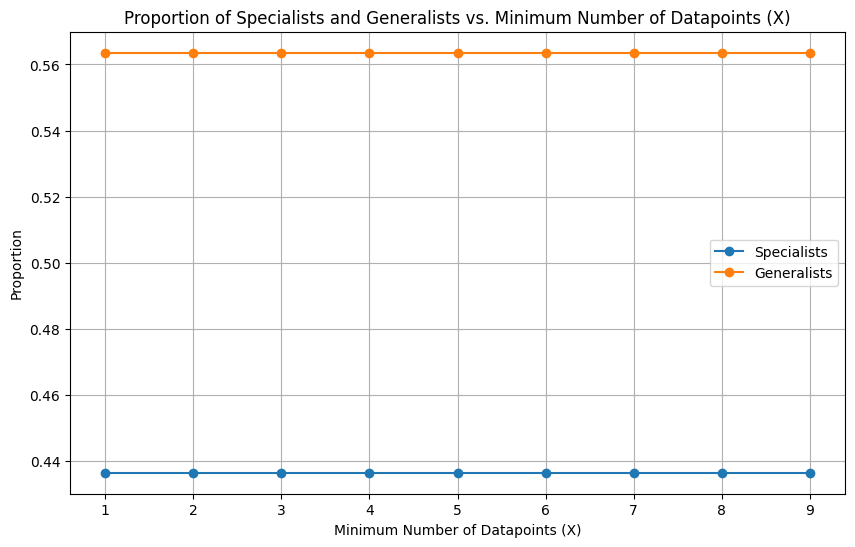

In [ ]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

def calculate_average_cosine_similarity(group):
    embeddings = np.array(group['embedding'].tolist())
    n = len(embeddings)
    if n < 2:
        return 0  # Not enough points to calculate similarity
    cosine_similarities = []
    for i in range(n):
        for j in range(i + 1, n):
            cosine_similarities.append(1 - cosine(embeddings[i], embeddings[j]))
    return np.median(cosine_similarities)

# Aggregate by person and calculate average cosine similarity
similarity_df_1 = adviser_description_df.groupby('person').apply(calculate_average_cosine_similarity).reset_index()
similarity_df_1.columns = ['person', 'average_cosine_similarity']

# Calculate the overall average cosine similarity across all persons
overall_average_similarity = similarity_df_1['average_cosine_similarity'].median()

# Set the minimum number of datapoints required
min_datapoints = 3

# Calculate the number of datapoints for each person
counts = adviser_description_df['person'].value_counts().reset_index()
counts.columns = ['person', 'count']

# Merge the counts with the similarity dataframe
similarity_df_1 = similarity_df_1.merge(counts, on='person')

# Label each person as "specialist" or "generalist" or "NA"
def label_person(row, overall_average_similarity, min_datapoints):
    if row['count'] < min_datapoints:
        return 'NA'
    elif row['average_cosine_similarity'] > overall_average_similarity:
        return 'generalist'
    else:
        return 'specialist'

similarity_df_1['label'] = similarity_df_1.apply(label_person, axis=1, overall_average_similarity=overall_average_similarity, min_datapoints=min_datapoints)

# Display the similarity DataFrame with labels
print(similarity_df_1)

# Initialize lists to store proportions
x_values = range(1, 10)
proportion_specialists = []
proportion_generalists = []

# Calculate proportions for each value of X
for min_datapoints in x_values:
    similarity_df_1['label'] = similarity_df_1.apply(label_person, axis=1, overall_average_similarity=overall_average_similarity, min_datapoints=min_datapoints)
    total = similarity_df['label'].value_counts()
    num_specialists = total.get('specialist', 0)
    num_generalists = total.get('generalist', 0)
    num_total = num_specialists + num_generalists
    if num_total > 0:
        proportion_specialists.append(num_specialists / num_total)
        proportion_generalists.append(num_generalists / num_total)
    else:
        proportion_specialists.append(0)
        proportion_generalists.append(0)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'X': x_values,
    'Proportion_Specialists': proportion_specialists,
    'Proportion_Generalists': proportion_generalists
})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(plot_df['X'], plot_df['Proportion_Specialists'], label='Specialists', marker='o')
plt.plot(plot_df['X'], plot_df['Proportion_Generalists'], label='Generalists', marker='o')
plt.xlabel('Minimum Number of Datapoints (X)')
plt.ylabel('Proportion')
plt.title('Proportion of Specialists and Generalists vs. Minimum Number of Datapoints (X)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
adviser_description_df

,adviser_id,first-name,name,text,start,end,person,x,y,embedding
0,6425,Mariam,AL MERROUNI,PA van de partijwoordvoerder at N-VA:,2010.0,2023.0,Mariam AL MERROUNI,6.816408,0.685994,"[6.816408, 0.6859939, 11.364078, 2.1150355, 3...."
1,6425,Mariam,AL MERROUNI,Deskundige Communicatiebeheerder at Provincie ...,2001.0,2010.0,Mariam AL MERROUNI,8.816537,-0.981547,"[8.816537, -0.9815471, 9.352718, 1.8073529, 1...."
2,6425,Mariam,AL MERROUNI,Adviseur (communicatie) at Minister-president ...,2019.0,2022.0,Mariam AL MERROUNI,8.450776,0.246611,"[8.450776, 0.24661125, 7.857404, 4.240616, 0.7..."
3,6429,Peter,RAEYMAEKERS,Spin-off Project Manager at KULeuven:,2006.0,2009.0,Peter RAEYMAEKERS,9.243553,0.602544,"[9.243553, 0.6025437, 9.346387, 1.3608435, 1.6..."
4,6429,Peter,RAEYMAEKERS,Stafmedewerker at Zorgnet-Icuro:,2012.0,2023.0,Peter RAEYMAEKERS,7.987026,0.181022,"[7.9870257, 0.18102172, 9.374155, 1.5659267, 2..."
...,...,...,...,...,...,...,...,...,...,...
4809,8423,Willy,INDEKEU,Uitv. personeel at Minister-president van de V...,2003.0,2004.0,Willy INDEKEU,7.344586,1.950341,"[7.3445864, 1.950341, 5.660634, 3.6672878, 0.6..."
4810,8423,Willy,INDEKEU,Uitv. personeel at Vlaams minister van Binnen...,2006.0,2009.0,Willy INDEKEU,7.979458,1.210254,"[7.979458, 1.2102544, 9.087265, 3.918266, 0.80..."
4811,8442,Ewout,DOX,Customer Service Advisor at IPG CONTACT SOLUTI...,2016.0,2017.0,Ewout DOX,9.415012,-0.318709,"[9.415012, -0.31870866, 9.64784, 2.0455704, 2...."
4812,8442,Ewout,DOX,Stafmedewerker online communicatie at N-VA:,2019.0,2023.0,Ewout DOX,8.908847,-0.962686,"[8.908847, -0.96268624, 9.501757, 1.8189292, 1..."


In [ ]:
similarity_df_1

,person,average_cosine_similarity,count,label
0,DE CEUSTER,0.972794,9,specialist
1,Adelheid ROSSEEL,0.966263,8,NA
2,Adinda VAN GEYSTELEN,0.996292,16,generalist
3,Aidan REINQUIN,0.962194,13,specialist
4,Alexander VANDERSMISSEN,0.960201,9,specialist
...,...,...,...,...
620,Yago BASTIN,0.962585,7,NA
621,Yamila IDRISSI,0.968183,18,specialist
622,Yann VAN ROMPAEY,0.950868,5,NA
623,Yves DE KEYZER,0.992971,5,NA


In [ ]:
similarity_df['person'] = similarity_df['person'].str.lower()
similarity_df_1['person'] = similarity_df_1['person'].str.lower()

# Rename columns to include suffix
similarity_df = similarity_df.rename(columns={
    'average_cosine_similarity': 'average_cosine_similarity_0',
    'label': 'label_0'
})

similarity_df_1 = similarity_df_1.rename(columns={
    'average_cosine_similarity': 'average_cosine_similarity_1',
    'label': 'label_1'
})

# Merge DataFrames on 'person' column
merged_df = pd.merge(similarity_df, similarity_df_1, on='person', how='outer')
filtered_df = merged_df.dropna(subset=['average_cosine_similarity_0', 'average_cosine_similarity_1'])

# Display the merged DataFrame
print(filtered_df)

                      person  average_cosine_similarity_0  count_x  \
0                 de ceuster                     0.988560    200.0   
1             aidan reinquin                     0.981926     56.0   
2    alexander vandersmissen                     0.987923    200.0   
3             allessia claes                     0.906120    200.0   
4                   an moons                     0.999989    200.0   
..                       ...                          ...      ...   
294        wouter coussement                     0.000000      1.0   
295               wouter pas                     0.991318    200.0   
296             wouter patho                     0.988476    200.0   
297              yago bastin                     0.000000      1.0   
298           yves de keyzer                     0.000000      1.0   

        label_0  average_cosine_similarity_1  count_y     label_1  
0    generalist                     0.972794        9  specialist  
1            NA        

In [ ]:
import scipy

spro_pol = scipy.stats.spearmanr(filtered_df['average_cosine_similarity_0'], filtered_df['average_cosine_similarity_1'], nan_policy='omit')
print(spro_pol)


SignificanceResult(statistic=-0.05790773111861026, pvalue=0.3182979027725821)


In [ ]:
url_positions = 'https://linkedin-parsing-49a53bd295b9.herokuapp.com/advisers/'
adviser_list = (adv for adv in linked_advisers if len(adv['positions']) == 0)
for adviser in adviser_list:
  response_positions = requests.get(url_positions + str(adviser['id']) + "/positions", headers=headers)
  for position in response_positions.json():
    start_date = extract_year(position['start-date'])
    end_date = extract_year(position['end-date'])
    url_codes = 'https://linkedin-parsing-49a53bd295b9.herokuapp.com/positions/' + str(position['id']) + '/codes'
    response_codes = requests.get(url_codes, headers=headers)
    for code in response_codes.json():
      if code['name'] == 'sector':
        adviser['positions'].append({'start': start_date, 'end': end_date, 'value': code['value'], 'workplace': position['workplace'], 'title': position['title']})

error parsing: 2021-11-31
error parsing: juillet 2017
error parsing: Unknown
error parsing: Unknown
error parsing: 
error parsing: 
error parsing: 
error parsing: 
error parsing: None
error parsing: None
error parsing: 
error parsing: 
error parsing: 
error parsing: 
error parsing: 
error parsing: 
error parsing: 
error parsing: 
error parsing: None
error parsing: None
error parsing: mai 2013
error parsing: Ocotober 2006
error parsing: 
error parsing: 
error parsing: None
error parsing: None
error parsing: novembre 2017
error parsing: janvier 2010
error parsing: novembre 2014
error parsing: novembre 2021
error parsing: juillet 2018
error parsing: octobre 2019
error parsing: novembre 2021
error parsing: novembre 2014
error parsing: décembre 2018
error parsing: juillet 2015
error parsing: novembre 2017
error parsing: octobre 2008
error parsing: décembre 2009
error parsing: octobre 2007
error parsing: septembre 2008
error parsing: None
error parsing: None
error parsing: 
error parsing: No

In [ ]:
linked_advisers

[{'id': 6425,
  'first-name': 'Mariam',
  'name': 'AL MERROUNI',
  'positions': [{'start': 2010,
    'end': 2023,
    'description': 'PA van de partijwoordvoerder at N-VA: '},
   {'start': 2001,
    'end': 2010,
    'description': 'Deskundige Communicatiebeheerder at Provincie Vlaams-Brabant: '},
   {'start': 2019,
    'end': 2022,
    'description': 'Adviseur (communicatie) at Minister-president van de Vlaamse Regering en Vlaams minister van Buitenlandse Zaken, Cultuur, ICT en Facilitair Management: EMPTY'}]},
 {'id': 6429,
  'first-name': 'Peter',
  'name': 'RAEYMAEKERS',
  'positions': [{'start': 2006,
    'end': 2009,
    'description': 'Spin-off Project Manager at KULeuven: '},
   {'start': 2012,
    'end': 2023,
    'description': 'Stafmedewerker at Zorgnet-Icuro: '},
   {'start': 2011,
    'end': 2012,
    'description': "Coordinator Flanders' Care at Flemish Government - Department of Welfare: "},
   {'start': 1998,
    'end': 2006,
    'description': 'Venture Development Manag

In [ ]:
linked_advisers

[{'id': 6425,
  'first-name': 'Mariam',
  'name': 'AL MERROUNI',
  'positions': [{'start': 2010,
    'end': 2023,
    'value': 'politics(centr)',
    'workplace': 'N-VA',
    'title': 'PA van de partijwoordvoerder'},
   {'start': 2001,
    'end': 2010,
    'value': 'public',
    'workplace': 'Provincie Vlaams-Brabant',
    'title': 'Deskundige Communicatiebeheerder'},
   {'start': 2019,
    'end': 2022,
    'value': 'politics(gov)',
    'workplace': 'Minister-president van de Vlaamse Regering en Vlaams minister van Buitenlandse Zaken, Cultuur, ICT en Facilitair Management',
    'title': 'Adviseur (communicatie)'}]},
 {'id': 6429,
  'first-name': 'Peter',
  'name': 'RAEYMAEKERS',
  'positions': [{'start': 2006,
    'end': 2009,
    'value': 'academia',
    'workplace': 'KULeuven',
    'title': 'Spin-off Project Manager'},
   {'start': 2012,
    'end': 2023,
    'value': 'civilsoc',
    'workplace': 'Zorgnet-Icuro',
    'title': 'Stafmedewerker'},
   {'start': 2011,
    'end': 2012,
    

In [ ]:
positions_codes_df = []
for adviser in linked_advisers:
  for position in adviser['positions']:
      positions_codes_df.append({'adviser_id': adviser['id'], 'first-name': adviser['first-name'], 'name': adviser['name'], 'start': position['start'], 'end': position['end'], 'workplace': position['workplace'], 'title': position['title'], 'value': position['value']})

positions_codes_df = pd.DataFrame(positions_codes_df)

In [ ]:
positions_codes_df.to_csv('/content/drive/MyDrive/positions_codes.csv')

In [ ]:
filtered_positions_codes_df = positions_codes_df[positions_codes_df['value'].str.contains('gov', case=False)]

In [ ]:
filtered_positions_codes_df

,adviser_id,first-name,name,start,end,workplace,title,value
2,6425,Mariam,AL MERROUNI,2019.0,2022.0,Minister-president van de Vlaamse Regering en ...,Adviseur (communicatie),politics(gov)
7,6429,Peter,RAEYMAEKERS,2009.0,2011.0,"Cabinet of the Flemish minister for welfare, p...",Advisor,politics(gov)
8,6436,Ayan,MOHAMUD YUSUF,2006.0,2006.0,De minister-president van de Vlaamse regering ...,Uitv. personeel,politics(gov)
9,6436,Ayan,MOHAMUD YUSUF,2014.0,2023.0,Vlaamse Overheid,Protocol verantwoordelijke & catering,politics(gov)
10,6436,Ayan,MOHAMUD YUSUF,2014.0,2023.0,Minister-president van de Vlaamse Regering,Protocol/ catering verantwoordelijk van de Vla...,politics(gov)
...,...,...,...,...,...,...,...,...
4801,8406,Rita,DE GRAEVE,2006.0,2006.0,"De Vlaamse minister van cultuur, jeugd, sport ...",RAADGEVER,politics(gov)
4810,8415,Pierre,DE SMEDT,2000.0,2004.0,"DE VLAAMSE MINISTER VAN WELZIJN, VOLKSGEZONDH...",Uitv. personeel,politics(gov)
4814,8423,Willy,INDEKEU,2003.0,2004.0,Minister-president van de Vlaamse regering,Uitv. personeel,politics(gov)
4815,8423,Willy,INDEKEU,2006.0,2009.0,"Vlaams minister van Binnenlands Bestuur, Sted...",Uitv. personeel,politics(gov)


In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from stop_words import get_stop_words

vectorizer_model = CountVectorizer(stop_words=get_stop_words('dutch'))
topic_model = BERTopic(calculate_probabilities=True, nr_topics='auto', vectorizer_model = vectorizer_model, language="multilingual")

text = filtered_positions_codes_df['workplace'].astype(str).tolist()

topics, probabilities = topic_model.fit_transform(text)
new_topics = topic_model.reduce_outliers(text, topics = topics, strategy='c-TF-IDF')
topic_model.update_topics(text, topics=new_topics)
topics_reduced, probabilities_reduced = topic_model.transform(text)

2024-07-10 16:11:32,518 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
topic_model.visualize_topics()